In [1]:
import os
from PIL import Image

In [1]:
import scipy
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [2]:
import plotly.io as pio
pio.renderers.default = 'svg'

In [4]:
import tensorflow as tf
# from tensorflow import keras
import tensorflow.keras as keras

2024-01-15 13:43:02.959611: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.xception import decode_predictions

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

In [7]:
data_dir_path = 'data/'

Class names are subfolder names in the data directory

In [8]:
class_names = os.listdir(data_dir_path)
class_count = len(class_names)

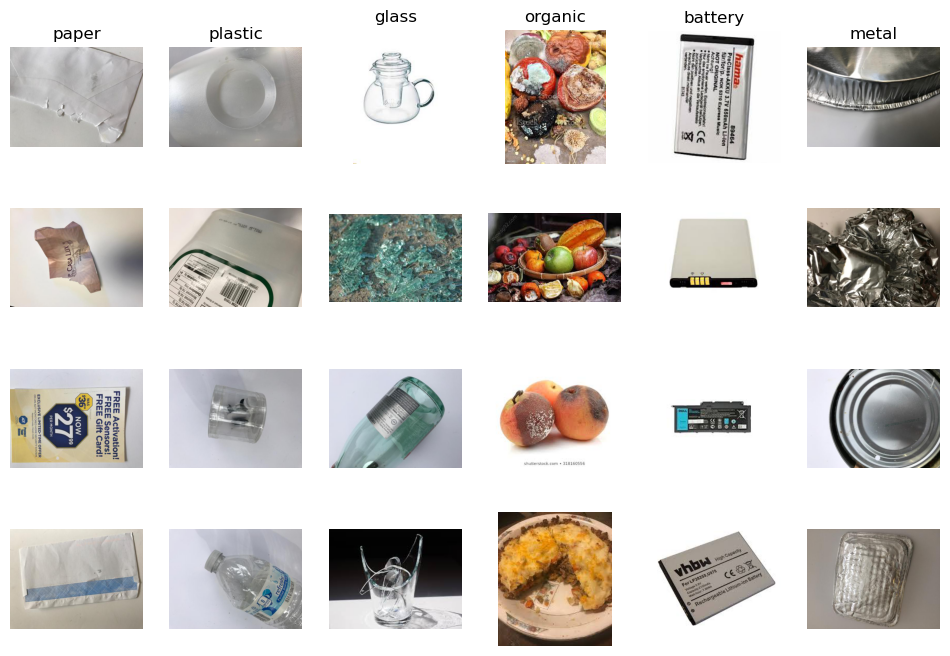

In [8]:
n = 4
img_counts = {}

fig, axes = plt.subplots(n, class_count, figsize=(12, 8))

# Iterate over subfolders:
for class_id, class_name in enumerate(class_names):
    class_dir_path = os.path.join(data_dir_path, class_name)
    
    # Record the number of image files in the current subfolder: 
    imgs = os.listdir(class_dir_path)
    img_counts[class_name] = len(imgs)
    
    # Iterate over first `n` image files in the subfolder:
    for img_id, img_name in enumerate(imgs[:n]):
        img_path = os.path.join(class_dir_path, img_name)
        img = load_img(img_path)
        
        # Display the image in row `img_id` and column `class_id`:
        ax = axes[img_id, class_id]
        ax.imshow(img)
        ax.axis('off')
        
        # Set title to top row of images only to reflect each class:
        if img_id == 0:
            ax.set_title(class_name)

In [9]:
img_counts

{'paper': 775,
 'plastic': 775,
 'glass': 775,
 'organic': 775,
 'battery': 775,
 'metal': 775}

In [10]:
total_img_count = sum(img_counts.values())
total_img_count

4650

In [11]:
# Initialize empty lists to store the information
img_name_class_pairs = []
sizes = []
resolutions = []

# Iterate over each image file in each subdirectory
for class_dir_path, _, imgs in os.walk(data_dir_path):
    class_name = class_dir_path[5:]
    for img_name in imgs:
        img_name_class_pairs.append((img_name, class_name))
        
        # Load the image file without loading the raster data
        img_path = os.path.join(class_dir_path, img_name)
        img = Image.open(img_path, mode="r")

        # Extract the size of the image
        size = os.path.getsize(img_path)
        sizes.append(size)

        # Extract the resolution of the image
        resolution = img.size
        resolutions.append(resolution)

In [12]:
img_df = pd.DataFrame(img_name_class_pairs, columns=['img_name', 'class'])
img_df['size_bytes'] = sizes
img_df['width_px'], img_df['height_px'] = zip(*resolutions)
img_df

,img_name,class,size_bytes,width_px,height_px
0,paper280.jpg,paper,13177,512,384
1,paper669.jpg,paper,11944,512,384
2,paper425.jpg,paper,26478,512,384
3,paper507.jpg,paper,16309,512,384
4,paper568.jpg,paper,22470,512,384
...,...,...,...,...,...
4645,metal610.jpg,metal,5129,240,210
4646,metal608.jpg,metal,10207,275,183
4647,metal320.jpg,metal,19299,512,384
4648,metal663.jpg,metal,3627,225,225


<AxesSubplot:xlabel='size_bytes', ylabel='Density'>

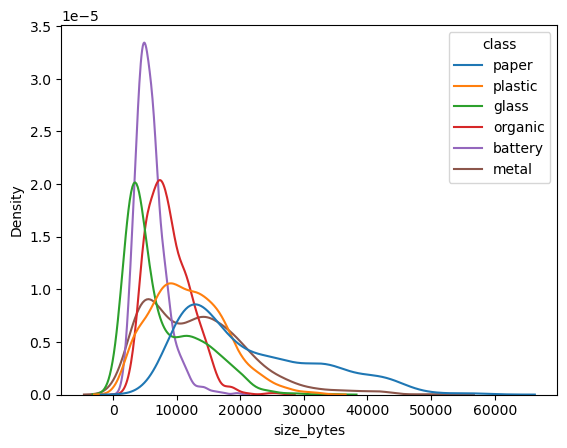

In [13]:
sns.kdeplot(img_df, x='size_bytes', hue='class')

<AxesSubplot:xlabel='width_px', ylabel='height_px'>

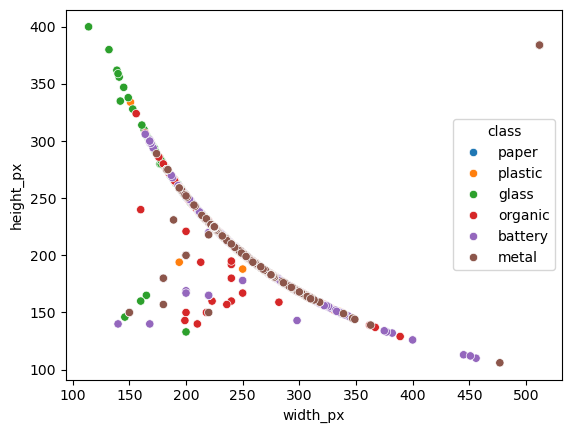

In [14]:
sns.scatterplot(img_df, x="width_px", y="height_px", hue="class")

In [15]:
img_df['width_px'].mean(), img_df['height_px'].mean()

(362.1761290322581, 285.3984946236559)

In [8]:
batch_size = 32
img_height = 150
img_width = 150

In [15]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)

val_ds = val_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=23,
    subset='validation')

Found 3720 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


In [11]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(img_width, img_height, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(class_count)(vectors)

model = keras.Model(inputs, outputs)

2024-01-11 12:11:12.609004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 12:11:12.618014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 12:11:12.618249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 12:11:12.618775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


2024-01-11 12:11:45.374074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-11 12:11:45.984508: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 12:11:45.985057: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 12:11:45.985104: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-11 12:11:45.985648: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 12:11:45.985743: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


117/117 [==============================] - 15s 89ms/step - loss: 1.3012 - accuracy: 0.5430 - val_loss: 1.2204 - val_accuracy: 0.5925
Epoch 2/10
117/117 [==============================] - 9s 78ms/step - loss: 0.7719 - accuracy: 0.7892 - val_loss: 0.9951 - val_accuracy: 0.6581
Epoch 3/10
117/117 [==============================] - 9s 78ms/step - loss: 0.5915 - accuracy: 0.8374 - val_loss: 0.8796 - val_accuracy: 0.6882
Epoch 4/10
117/117 [==============================] - 9s 77ms/step - loss: 0.4989 - accuracy: 0.8578 - val_loss: 0.8087 - val_accuracy: 0.7086
Epoch 5/10
117/117 [==============================] - 9s 76ms/step - loss: 0.4407 - accuracy: 0.8677 - val_loss: 0.7577 - val_accuracy: 0.7323
Epoch 6/10
117/117 [==============================] - 9s 77ms/step - loss: 0.3999 - accuracy: 0.8801 - val_loss: 0.7022 - val_accuracy: 0.7527
Epoch 7/10
117/117 [==============================] - 9s 76ms/step - loss: 0.3685 - accuracy: 0.8917 - val_loss: 0.6801 - val_accuracy: 0.7624
Epoch 8/1

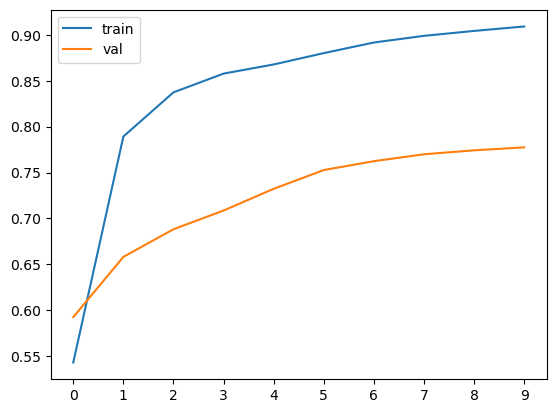

In [16]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

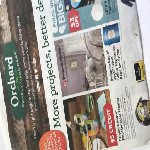

In [19]:
img_test = load_img('data/paper/paper83.jpg', target_size=(150, 150))
img_test

In [21]:
x = np.array(img_test)
X = np.array([x])
X = preprocess_input(X)

In [22]:
pred = model.predict(X)

1/1 [==============================] - 1s 979ms/step


In [24]:
dict(zip(train_ds.class_indices.keys(), pred[0]))

{'battery': -1.0054861,
 'glass': -2.6026208,
 'metal': -2.839804,
 'organic': -2.8846633,
 'paper': 2.009806,
 'plastic': -0.8603484}

In [10]:
def make_model(base_model, learning_rate=0.001, size_inner=None,
               droprate=None):

    base_model.trainable = False
    
    # Generate the vector representation of the base model
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Add an optional inner dense layer
    if size_inner is not None:
        inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    else:
        inner = vectors
        
    # Add an optional dropout layer
    if droprate is not None:
        drop = keras.layers.Dropout(droprate)(inner)
    else:
        drop = inner
        
    # Generate the outer dense layer and link the model 
    outputs = keras.layers.Dense(6)(drop)
    model = keras.Model(inputs, outputs)
    
    # Define the optimizer learning rate and the loss function
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

# Xception

In [11]:
xception_base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

2024-01-15 13:44:04.430042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 13:44:04.436140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 13:44:04.436383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 13:44:04.436968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [11]:
model = make_model(xception_base_model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20


2024-01-12 16:03:29.045714: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-12 16:03:29.694785: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:03:29.695306: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:03:29.695338: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-12 16:03:29.695988: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:03:29.696077: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


117/117 [==============================] - 18s 116ms/step - loss: 0.5668 - accuracy: 0.8108 - val_loss: 0.5781 - val_accuracy: 0.7882
Epoch 2/20
117/117 [==============================] - 10s 86ms/step - loss: 0.2730 - accuracy: 0.9105 - val_loss: 0.5757 - val_accuracy: 0.7839
Epoch 3/20
117/117 [==============================] - 10s 86ms/step - loss: 0.2067 - accuracy: 0.9376 - val_loss: 0.4934 - val_accuracy: 0.8065
Epoch 4/20
117/117 [==============================] - 10s 86ms/step - loss: 0.1669 - accuracy: 0.9530 - val_loss: 0.4730 - val_accuracy: 0.8204
Epoch 5/20
117/117 [==============================] - 10s 85ms/step - loss: 0.1350 - accuracy: 0.9648 - val_loss: 0.4510 - val_accuracy: 0.8280
Epoch 6/20
117/117 [==============================] - 10s 85ms/step - loss: 0.1149 - accuracy: 0.9718 - val_loss: 0.4355 - val_accuracy: 0.8409
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.0991 - accuracy: 0.9758 - val_loss: 0.4482 - val_accuracy: 0.8398
Ep

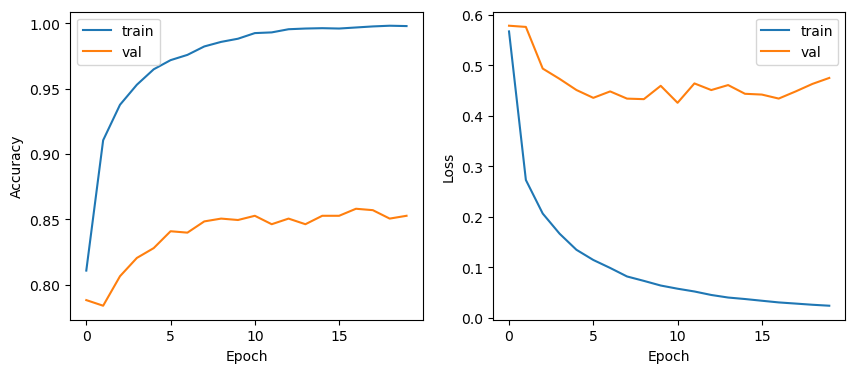

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history.history['accuracy'], label='train')
ax1.plot(history.history['val_accuracy'], label='val')
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
# ax1.set_xticks(np.arange(5))
ax1.legend()

ax2.plot(history.history['loss'], label='train')
ax2.plot(history.history['val_loss'], label='val')
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
# ax2.set_xticks(np.arange(5))
ax2.legend()

In [16]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('learning_rate=%s' % lr)

    model = make_model(xception_base_model, learning_rate=lr)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

learning_rate=0.0001
Epoch 1/20
117/117 [==============================] - 13s 93ms/step - loss: 1.4073 - accuracy: 0.4944 - val_loss: 1.2140 - val_accuracy: 0.5828
Epoch 2/20
117/117 [==============================] - 10s 86ms/step - loss: 0.8127 - accuracy: 0.7809 - val_loss: 0.9668 - val_accuracy: 0.6677
Epoch 3/20
117/117 [==============================] - 10s 86ms/step - loss: 0.6099 - accuracy: 0.8274 - val_loss: 0.8682 - val_accuracy: 0.6946
Epoch 4/20
117/117 [==============================] - 10s 86ms/step - loss: 0.5119 - accuracy: 0.8527 - val_loss: 0.7994 - val_accuracy: 0.7183
Epoch 5/20
117/117 [==============================] - 10s 87ms/step - loss: 0.4511 - accuracy: 0.8661 - val_loss: 0.7399 - val_accuracy: 0.7344
Epoch 6/20
117/117 [==============================] - 10s 86ms/step - loss: 0.4084 - accuracy: 0.8806 - val_loss: 0.6990 - val_accuracy: 0.7527
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.3762 - accuracy: 0.8911 - val_loss: 0

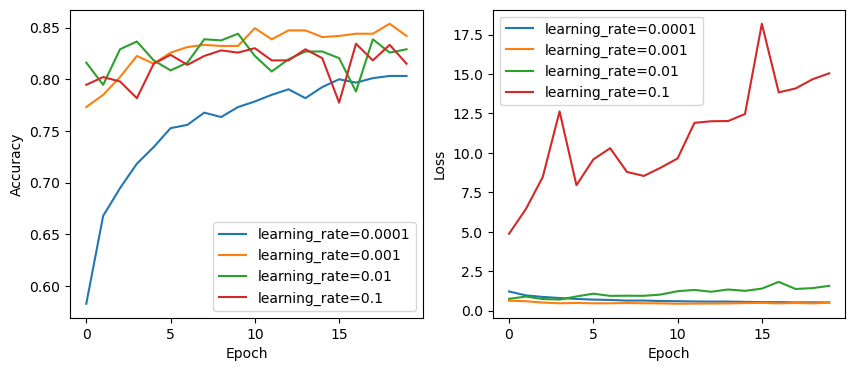

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for lr, hist in scores.items():
    ax1.plot(hist['val_accuracy'], label=('lr=%s' % lr))
    ax2.plot(hist['val_loss'], label=('lr=%s' % lr))
    
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid()

ax2.set_ylabel("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()

plt.suptitle("Learning Rate Parameter Tuning for Xception-based Model")

In [16]:
learning_rate = 0.001

scores = {}

for size in [None, 10, 100, 1000]:
    print('size_inner=%s' % size)

    model = make_model(xception_base_model, learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

size_inner=None
Epoch 1/20
117/117 [==============================] - 13s 91ms/step - loss: 0.5735 - accuracy: 0.8019 - val_loss: 0.6302 - val_accuracy: 0.7677
Epoch 2/20
117/117 [==============================] - 10s 85ms/step - loss: 0.2746 - accuracy: 0.9097 - val_loss: 0.5592 - val_accuracy: 0.7892
Epoch 3/20
117/117 [==============================] - 10s 83ms/step - loss: 0.2060 - accuracy: 0.9374 - val_loss: 0.5566 - val_accuracy: 0.7892
Epoch 4/20
117/117 [==============================] - 10s 86ms/step - loss: 0.1666 - accuracy: 0.9495 - val_loss: 0.4816 - val_accuracy: 0.8215
Epoch 5/20
117/117 [==============================] - 10s 84ms/step - loss: 0.1361 - accuracy: 0.9621 - val_loss: 0.4480 - val_accuracy: 0.8419
Epoch 6/20
117/117 [==============================] - 10s 86ms/step - loss: 0.1144 - accuracy: 0.9699 - val_loss: 0.4194 - val_accuracy: 0.8505
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.0992 - accuracy: 0.9766 - val_loss: 0.4342

Text(0.5, 0.98, 'Size of Inner Layer Tuning for Xception-based Model')

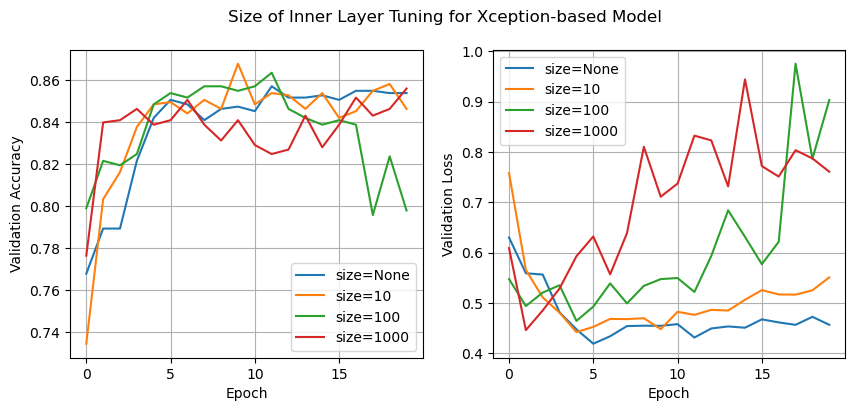

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for size, hist in scores.items():
    ax1.plot(hist['val_accuracy'], label=('size=%s' % size))
    ax2.plot(hist['val_loss'], label=('size=%s' % size))
    
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid()

ax2.set_ylabel("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()

plt.suptitle("Size of Inner Layer Tuning for Xception-based Model")

In [12]:
learning_rate = 0.001
size = 10

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:    
    print('droprate=%s' % droprate)

    model = make_model(xception_base_model, 
                       learning_rate=learning_rate,
                       size_inner=size,
                       droprate=droprate
                      )
    
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

droprate=0.0
Epoch 1/20


2024-01-15 13:44:46.564003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-15 13:44:47.239809: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 13:44:47.240483: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 13:44:47.240530: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-15 13:44:47.241190: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 13:44:47.241302: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


117/117 [==============================] - 18s 116ms/step - loss: 0.7048 - accuracy: 0.7556 - val_loss: 0.6385 - val_accuracy: 0.7581
Epoch 2/20
117/117 [==============================] - 10s 85ms/step - loss: 0.2732 - accuracy: 0.9151 - val_loss: 0.5221 - val_accuracy: 0.8172
Epoch 3/20
117/117 [==============================] - 10s 84ms/step - loss: 0.1904 - accuracy: 0.9409 - val_loss: 0.5267 - val_accuracy: 0.8129
Epoch 4/20
117/117 [==============================] - 10s 85ms/step - loss: 0.1458 - accuracy: 0.9583 - val_loss: 0.4609 - val_accuracy: 0.8344
Epoch 5/20
117/117 [==============================] - 10s 84ms/step - loss: 0.1120 - accuracy: 0.9696 - val_loss: 0.4823 - val_accuracy: 0.8409
Epoch 6/20
117/117 [==============================] - 10s 85ms/step - loss: 0.0866 - accuracy: 0.9788 - val_loss: 0.4478 - val_accuracy: 0.8398
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.0743 - accuracy: 0.9809 - val_loss: 0.4603 - val_accuracy: 0.8505
Ep

Text(0.5, 0.98, 'Droprate Parameter Tuning for Xception-based Model')

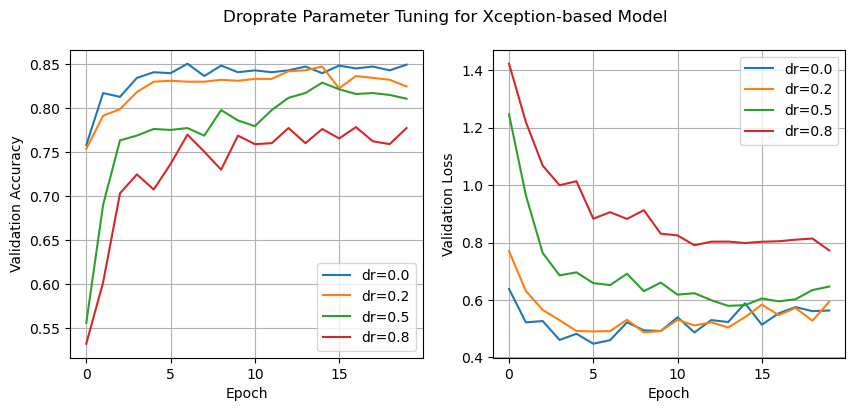

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for dr, hist in scores.items():
    ax1.plot(hist['val_accuracy'], label=('dr=%s' % dr))
    ax2.plot(hist['val_loss'], label=('dr=%s' % dr))
    
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid()

ax2.set_ylabel("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()

plt.suptitle("Droprate Parameter Tuning for Xception-based Model")

In [ ]:
hist_no_aug = scores[0.2]

scores = {}

In [18]:
learning_rate = 0.001
size = 10
droprate = 0.2

model = make_model(xception_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

hist_no_aug = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
117/117 [==============================] - 13s 93ms/step - loss: 1.1055 - accuracy: 0.5785 - val_loss: 0.8694 - val_accuracy: 0.6731
Epoch 2/20
117/117 [==============================] - 10s 87ms/step - loss: 0.6507 - accuracy: 0.7543 - val_loss: 0.6804 - val_accuracy: 0.7785
Epoch 3/20
117/117 [==============================] - 10s 86ms/step - loss: 0.5066 - accuracy: 0.8156 - val_loss: 0.6190 - val_accuracy: 0.7860
Epoch 4/20
117/117 [==============================] - 10s 85ms/step - loss: 0.4248 - accuracy: 0.8513 - val_loss: 0.5700 - val_accuracy: 0.7989
Epoch 5/20
117/117 [==============================] - 10s 86ms/step - loss: 0.3763 - accuracy: 0.8704 - val_loss: 0.5524 - val_accuracy: 0.8032
Epoch 6/20
117/117 [==============================] - 10s 86ms/step - loss: 0.3396 - accuracy: 0.8925 - val_loss: 0.5367 - val_accuracy: 0.8118
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.2934 - accuracy: 0.8952 - val_loss: 0.5506 - val_accuracy:

In [19]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [20]:
model = make_model(xception_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['rotation'] = history.history

Epoch 1/20
117/117 [==============================] - 28s 220ms/step - loss: 0.9269 - accuracy: 0.6468 - val_loss: 0.7424 - val_accuracy: 0.7581
Epoch 2/20
117/117 [==============================] - 25s 213ms/step - loss: 0.5698 - accuracy: 0.7981 - val_loss: 0.6192 - val_accuracy: 0.7871
Epoch 3/20
117/117 [==============================] - 25s 211ms/step - loss: 0.4706 - accuracy: 0.8344 - val_loss: 0.5420 - val_accuracy: 0.8032
Epoch 4/20
117/117 [==============================] - 25s 215ms/step - loss: 0.4031 - accuracy: 0.8540 - val_loss: 0.5625 - val_accuracy: 0.7957
Epoch 5/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3612 - accuracy: 0.8750 - val_loss: 0.5362 - val_accuracy: 0.8043
Epoch 6/20
117/117 [==============================] - 25s 214ms/step - loss: 0.3191 - accuracy: 0.8839 - val_loss: 0.5171 - val_accuracy: 0.8129
Epoch 7/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3041 - accuracy: 0.8898 - val_loss: 0.4823 - val_ac

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
#     rotation_range=20,
    width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [22]:
model = make_model(xception_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['width_shift'] = history.history

Epoch 1/20
117/117 [==============================] - 28s 220ms/step - loss: 0.9402 - accuracy: 0.6435 - val_loss: 0.7640 - val_accuracy: 0.7430
Epoch 2/20
117/117 [==============================] - 25s 213ms/step - loss: 0.5689 - accuracy: 0.8030 - val_loss: 0.6976 - val_accuracy: 0.7591
Epoch 3/20
117/117 [==============================] - 25s 214ms/step - loss: 0.4622 - accuracy: 0.8470 - val_loss: 0.5981 - val_accuracy: 0.7946
Epoch 4/20
117/117 [==============================] - 25s 213ms/step - loss: 0.4237 - accuracy: 0.8430 - val_loss: 0.5731 - val_accuracy: 0.7935
Epoch 5/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3739 - accuracy: 0.8659 - val_loss: 0.5379 - val_accuracy: 0.8108
Epoch 6/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3473 - accuracy: 0.8728 - val_loss: 0.5243 - val_accuracy: 0.8204
Epoch 7/20
117/117 [==============================] - 25s 212ms/step - loss: 0.3163 - accuracy: 0.8839 - val_loss: 0.5342 - val_ac

In [23]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
#     rotation_range=20,
#     width_shift_range=0.2,
    height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [24]:
model = make_model(xception_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['height_shift'] = history.history

Epoch 1/20
117/117 [==============================] - 28s 220ms/step - loss: 0.8619 - accuracy: 0.6874 - val_loss: 0.7540 - val_accuracy: 0.7570
Epoch 2/20
117/117 [==============================] - 25s 214ms/step - loss: 0.5235 - accuracy: 0.8247 - val_loss: 0.6682 - val_accuracy: 0.7785
Epoch 3/20
117/117 [==============================] - 25s 214ms/step - loss: 0.4331 - accuracy: 0.8476 - val_loss: 0.5793 - val_accuracy: 0.7968
Epoch 4/20
117/117 [==============================] - 25s 216ms/step - loss: 0.3953 - accuracy: 0.8642 - val_loss: 0.5801 - val_accuracy: 0.8065
Epoch 5/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3487 - accuracy: 0.8750 - val_loss: 0.5323 - val_accuracy: 0.8086
Epoch 6/20
117/117 [==============================] - 25s 214ms/step - loss: 0.3078 - accuracy: 0.8957 - val_loss: 0.5168 - val_accuracy: 0.8140
Epoch 7/20
117/117 [==============================] - 25s 213ms/step - loss: 0.3072 - accuracy: 0.8839 - val_loss: 0.5091 - val_ac

In [25]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [26]:
model = make_model(xception_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['shear'] = history.history

Epoch 1/20
117/117 [==============================] - 28s 218ms/step - loss: 0.9230 - accuracy: 0.6616 - val_loss: 0.7873 - val_accuracy: 0.7462
Epoch 2/20
117/117 [==============================] - 24s 209ms/step - loss: 0.5295 - accuracy: 0.8134 - val_loss: 0.6062 - val_accuracy: 0.7925
Epoch 3/20
117/117 [==============================] - 25s 210ms/step - loss: 0.4447 - accuracy: 0.8304 - val_loss: 0.5575 - val_accuracy: 0.8011
Epoch 4/20
117/117 [==============================] - 25s 209ms/step - loss: 0.3928 - accuracy: 0.8524 - val_loss: 0.5500 - val_accuracy: 0.8108
Epoch 5/20
117/117 [==============================] - 25s 210ms/step - loss: 0.3356 - accuracy: 0.8715 - val_loss: 0.5496 - val_accuracy: 0.8161
Epoch 6/20
117/117 [==============================] - 25s 209ms/step - loss: 0.3067 - accuracy: 0.8798 - val_loss: 0.5106 - val_accuracy: 0.8258
Epoch 7/20
117/117 [==============================] - 25s 209ms/step - loss: 0.2849 - accuracy: 0.8890 - val_loss: 0.5095 - val_ac

In [32]:
del scores[10]
del scores[100]
del scores[1000]

In [35]:
del scores[None]

Text(0.5, 0.98, 'Data Augmentation Selection for Xception-based Model')

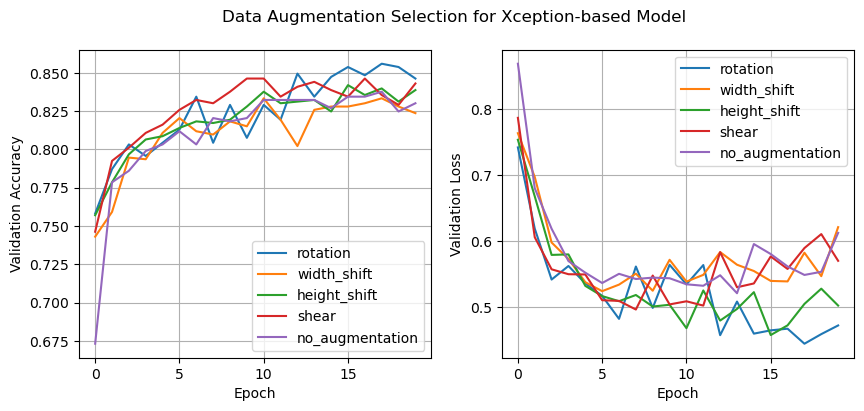

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for aug, hist in scores.items():
    ax1.plot(hist['val_accuracy'], label=aug)
    ax2.plot(hist['val_loss'], label=aug)
    
ax1.plot(hist_no_aug.history['val_accuracy'], label='no_augmentation')
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid()

ax2.plot(hist_no_aug.history['val_loss'], label='no_augmentation')
ax2.set_ylabel("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()

plt.suptitle("Data Augmentation Selection for Xception-based Model")

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2)

val_ds = val_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=23,
    subset='validation')

In [ ]:
resnet50_base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [ ]:
model = make_model(resnet50_base_model)
model.summary()

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

In [5]:
training_history = {
    'loss': [0.5, 0.4, 0.3, 0.2, 0.1],  # Training loss values for each epoch
    'accuracy': [0.75, 0.80, 0.85, 0.90, 0.95],  # Training accuracy values for each epoch
    'val_loss': [0.6, 0.5, 0.4, 0.3, 0.2],  # Validation loss values for each epoch
    'val_accuracy': [0.70, 0.75, 0.80, 0.85, 0.90]  # Validation accuracy values for each epoch
}

In [12]:
training_history2 = {
    'loss': [0.1, 0.1, 0.1, 0.1, 0.1],  # Training loss values for each epoch
    'accuracy': [0.5, 0.5, 0.5, 0.5, 0.5],  # Training accuracy values for each epoch
    'val_loss': [0.6, 0.5, 0.4, 0.3, 0.2],  # Validation loss values for each epoch
    'val_accuracy': [0.70, 0.75, 0.80, 0.85, 0.90]  # Validation accuracy values for each epoch
}

In [13]:
aaa = {}
aaa['a'] = training_history
aaa['b'] = training_history2

In [14]:
aaa

{'a': {'loss': [0.5, 0.4, 0.3, 0.2, 0.1],
  'accuracy': [0.75, 0.8, 0.85, 0.9, 0.95],
  'val_loss': [0.6, 0.5, 0.4, 0.3, 0.2],
  'val_accuracy': [0.7, 0.75, 0.8, 0.85, 0.9]},
 'b': {'loss': [0.1, 0.1, 0.1, 0.1, 0.1],
  'accuracy': [0.5, 0.5, 0.5, 0.5, 0.5],
  'val_loss': [0.6, 0.5, 0.4, 0.3, 0.2],
  'val_accuracy': [0.7, 0.75, 0.8, 0.85, 0.9]}}

In [15]:
colors = ['red', 'blue', 'green', 'gold']

In [22]:
for A, B in zip(aaa, colors):
#     A1, A2 = A.items()
    print(aaa[A]['loss'])
    print(B)

[0.5, 0.4, 0.3, 0.2, 0.1]
red
[0.1, 0.1, 0.1, 0.1, 0.1]
blue


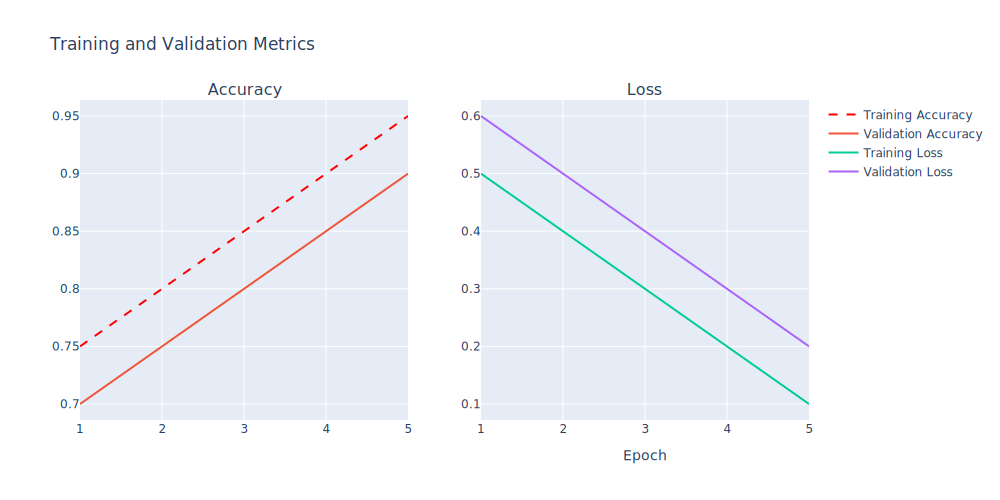

In [13]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Sample data (replace this with your actual data)
x_values = list(range(1, 6))
training_accuracy = [0.75, 0.80, 0.85, 0.90, 0.95]
validation_accuracy = [0.70, 0.75, 0.80, 0.85, 0.90]
training_loss = [0.5, 0.4, 0.3, 0.2, 0.1]
validation_loss = [0.6, 0.5, 0.4, 0.3, 0.2]

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

# Add traces for accuracy
fig.add_trace(go.Scatter(x=x_values, y=training_accuracy, mode='lines', name='Training Accuracy', 
                         line=dict(color='red', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_values, y=validation_accuracy, mode='lines', name='Validation Accuracy'), row=1, col=1)

# Add traces for loss
fig.add_trace(go.Scatter(x=x_values, y=training_loss, mode='lines', name='Training Loss'), row=1, col=2)
fig.add_trace(go.Scatter(x=x_values, y=validation_loss, mode='lines', name='Validation Loss'), row=1, col=2)

# Update layout
fig.update_layout(title='Training and Validation Metrics', width=1000, height=500)
fig['layout']['xaxis2']['title']='Epoch'

# Show the plot
fig.show()


In [ ]:
colors = ['blue', 'orange', 'green', 'red']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for dr, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['accuracy'], 
                             mode='lines', name='Training', row=1, col=1, 
                             line=dict(color=color, dash='dash')))
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['val_accuracy'], 
                             mode='lines', name='Training', row=1, col=1, 
                             line=dict(color=color)))
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['loss'], 
                             mode='lines', name='Training', row=1, col=2, 
                             line=dict(color=color, dash='dash')))
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['val_loss'], 
                             mode='lines', name='Training', row=1, col=2, 
                             line=dict(color=color)))
    
fig.update_layout(title="Droprate Parameter Tuning for Xception-based Model")
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()